In [148]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [149]:
data = pd.read_csv('./data/rice_train.csv')

In [150]:
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.578979,229.749878,85.093788,0.928882,15617,0.572896,1
1,14656,494.311005,206.020065,91.730972,0.895405,15072,0.615436,1
2,14634,501.122009,214.106781,87.768288,0.912118,14954,0.693259,1
3,13176,458.342987,193.337387,87.448395,0.891861,13368,0.640669,1
4,14688,507.166992,211.743378,89.312454,0.906691,15262,0.646024,1


#### Scalling data

In [151]:
features = data.drop('Class', axis=1)
target = data['Class']

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

features_scaled_df = pd.DataFrame(features_scaled, columns=features.columns)

data_scaled = pd.concat([features_scaled_df, target.reset_index(drop=True)], axis=1)
data_scaled.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.487825,2.013566,2.362099,-0.205793,2.032477,1.506705,-1.156478,1
1,1.155429,1.132847,0.996516,0.949586,0.410891,1.199658,-0.604632,1
2,1.142712,1.324691,1.461883,0.259775,1.220452,1.133178,0.404895,1
3,0.299872,0.119743,0.266664,0.204089,0.239219,0.239643,-0.277308,1
4,1.173928,1.494959,1.325876,0.528579,0.957566,1.306702,-0.207844,1


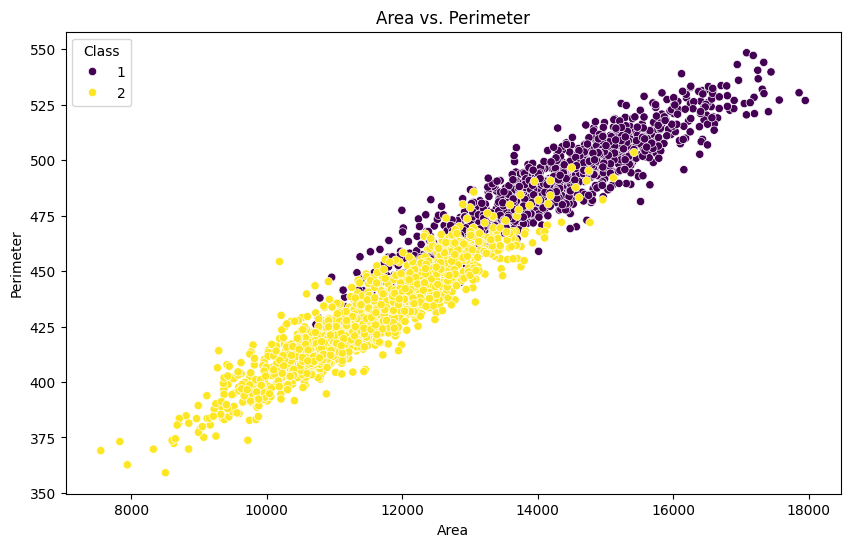

In [152]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Area', y='Perimeter', hue='Class', palette='viridis')
plt.title('Area vs. Perimeter')
plt.show()

#### First thing to notice is that area has a positive linear relation with perimeter

#### Secondly, as area or perimeter increase we see that classes become clearly separable by a single line

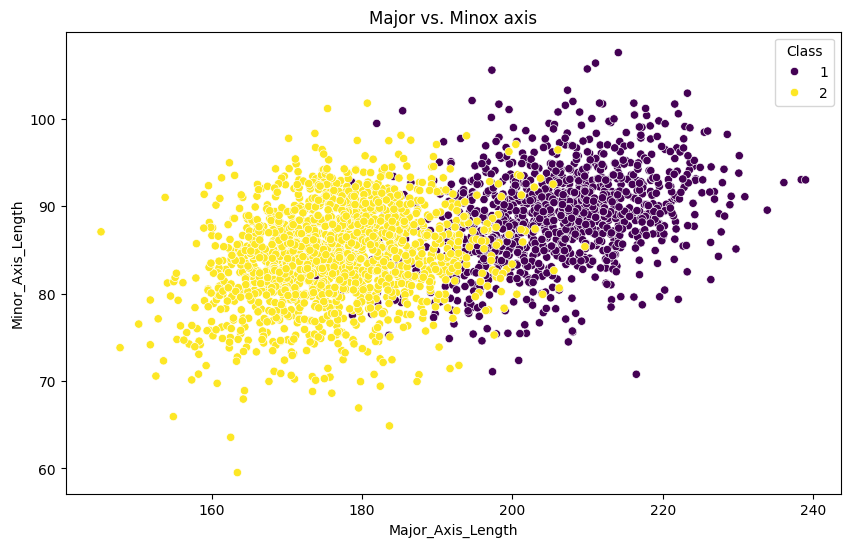

In [153]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='Major_Axis_Length', y='Minor_Axis_Length', hue='Class', palette='viridis')
plt.title('Major vs. Minox axis')
plt.show()

#### Here we see that major axis is a more important feature that a major axis

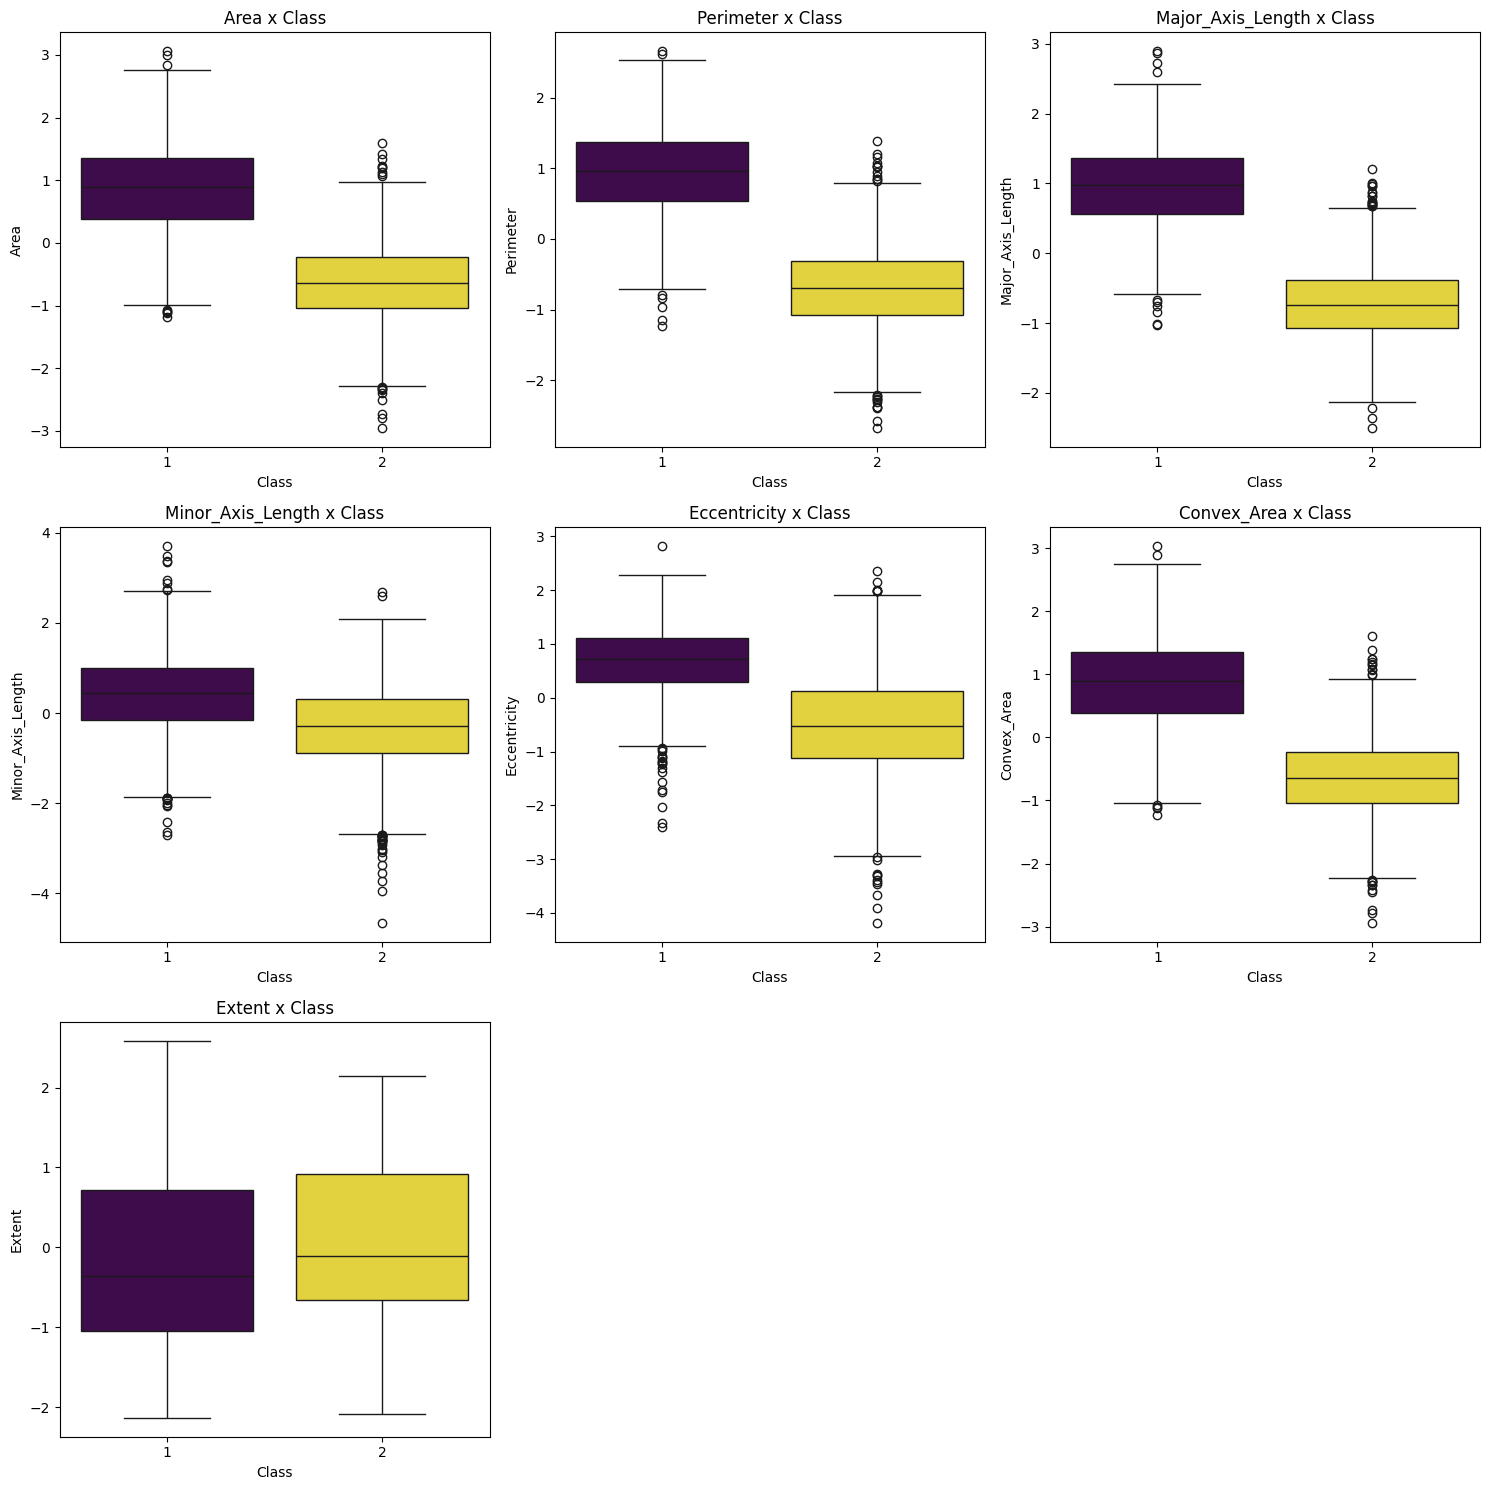

In [154]:
num_features = features_scaled_df.shape[1]
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

axes = axes.flatten()
for i, feature in enumerate(features_scaled_df.columns):
    sns.boxplot(data=data_scaled, x='Class', y=feature, hue='Class', ax=axes[i], palette='viridis', legend=False)
    axes[i].set_title(f'{feature} x Class')
    axes[i].set_xlabel('Class')
    axes[i].set_ylabel(feature)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### Firstly, looking at boxplots we definitely want to discard feature extent since it doesn't give any information about the class



#### As we previously saw Major axis gives much more information than minor axis

#### All other features have non overlaping IQR so they might be useful for class prediction

### The first graph suggested we have some correlated features. Let's look further into all of the correlations of the features (except the extent which we wont consider further)

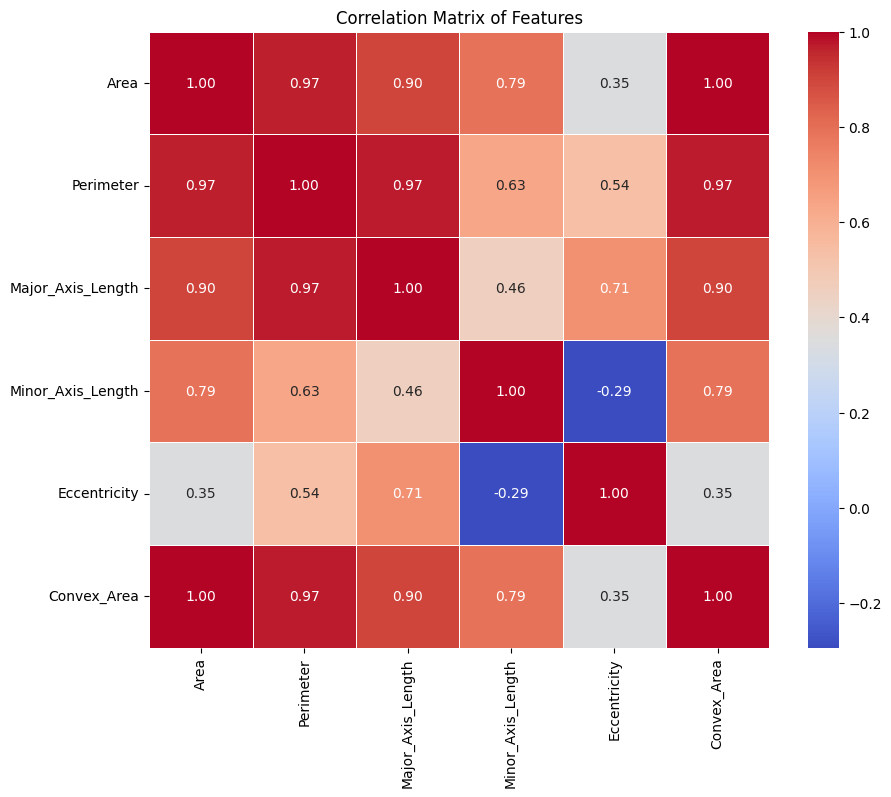

In [155]:
features = data[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area']]
correlation_matrix = features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

#### Correlation matrix shows us that all of our features are highly correlated to one another

#### To pick features manualy we consider picking the features that have the least redundancy and most information about the class

#### The feature that showed best promise from the boxplots was 
#### ----> Major Axis

#### Now looking at correlation we definetely want to avoid features Area/Convex Area (basicaly same features) and Perimeter.
#### I consider using Minor Axis as it has the lowest correlation with Major Axis, even thou boxplots were not ideal they still offer some new information about the class
#### ----> Minor Axis

#### Lastly, we pick Eccentricity as its correlation coefficient is on the edge of what would be considered highly correlated (this would be a matter of preference if we use another this feautre and a balance between redundancy and additional information for class distinction)
#### -----> Eccentricity

In [156]:
features = ['Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity']

## PCA
#### For the sake of comparison between manual feature picking and PCA

Principal Components (Loadings):
          Area  Perimeter  Major_Axis_Length  Minor_Axis_Length  Eccentricity  \
PCA1  0.461473   0.464450           0.446967           0.323937      0.223918   
PCA2 -0.122223   0.056031           0.215268          -0.565014      0.678088   

      Convex_Area    Extent  
PCA1     0.461896 -0.055917  
PCA2    -0.120626 -0.376812  


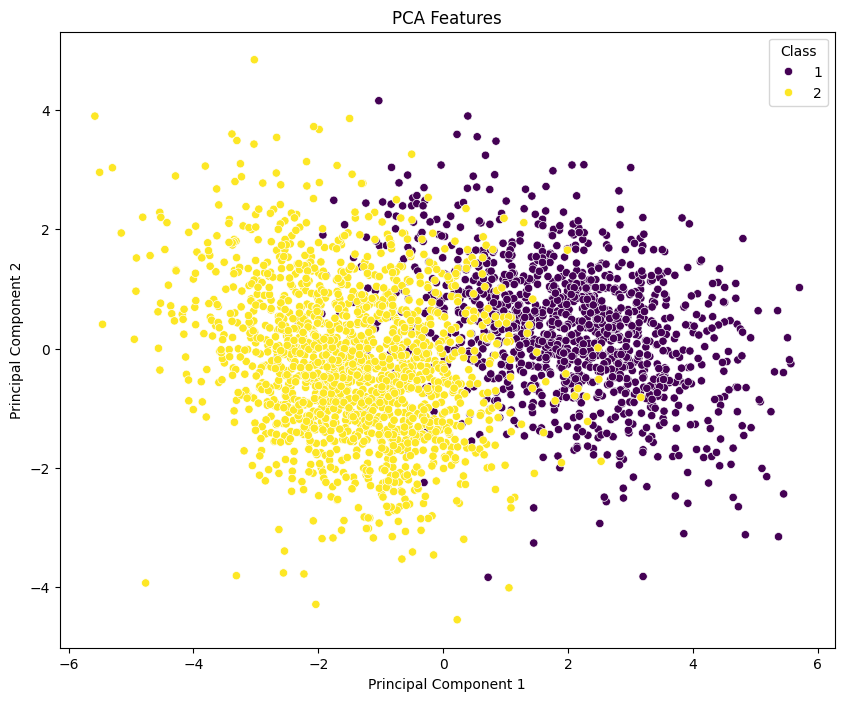

In [157]:
features_all = data_scaled[['Area', 'Perimeter', 'Major_Axis_Length', 'Minor_Axis_Length', 'Eccentricity', 'Convex_Area', 'Extent']]
pca = PCA(n_components=2)
features_pca  = pca.fit_transform(features_all)
data_pca = pd.DataFrame(features_pca, columns=['PCA1', 'PCA2'])
data_pca = pd.concat([data_pca, target.reset_index(drop=True)], axis=1)

original_feature_names = features_all.columns
principal_components = pca.components_
loadings_df = pd.DataFrame(principal_components, columns=original_feature_names, index=['PCA1', 'PCA2'])
print("Principal Components (Loadings):")
print(loadings_df)

plt.figure(figsize=(10, 8))
sns.scatterplot(data=data_pca, x='PCA1', y='PCA2', hue='Class', palette='viridis')
plt.title('PCA Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class')
plt.show()

## TRAIN-TEST-KFOLDS CROSS VALIDATION SPLIT

In [158]:
X = data_scaled[features]
y = data['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [159]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Logistic regression

In [160]:
model = LogisticRegression(max_iter=1000)
cv_results = cross_val_score(model, X_train, y_train, cv=kf, scoring='accuracy') # neg_mean_squared_error
print(f'Cross-validation accuracy scores: {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')

Cross-validation accuracy scores: [0.93555556 0.93333333 0.92888889 0.93541203 0.91536748]
Mean cross-validation accuracy: 0.9297114575600098


In [161]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test set accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Test set accuracy: 0.9234875444839857
Confusion Matrix:
[[217  22]
 [ 21 302]]
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.91      0.91       239
           2       0.93      0.93      0.93       323

    accuracy                           0.92       562
   macro avg       0.92      0.92      0.92       562
weighted avg       0.92      0.92      0.92       562



In [162]:
feature_importances = model.coef_[0]
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', key=abs, ascending=False).reset_index(drop=True)

In [163]:
print(importance_df)

             Feature  Importance
0  Major_Axis_Length   -2.566693
1       Eccentricity   -1.959467
2  Minor_Axis_Length   -1.486543


#### Here we confirm that Major axis was the most important feature in classification out of the ones we picked

### LDA

In [164]:
lda = LinearDiscriminantAnalysis()
cv_results = cross_val_score(lda, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')

Cross-validation accuracy scores: [0.94       0.93111111 0.92666667 0.93318486 0.91091314]
Mean cross-validation accuracy: 0.9283751546646869


In [165]:
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test set accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Test set accuracy: 0.9270462633451957
Confusion Matrix:
[[217  22]
 [ 19 304]]
Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.91      0.91       239
           2       0.93      0.94      0.94       323

    accuracy                           0.93       562
   macro avg       0.93      0.92      0.93       562
weighted avg       0.93      0.93      0.93       562



### QDA

In [166]:
lda = QuadraticDiscriminantAnalysis()
cv_results = cross_val_score(lda, X_train, y_train, cv=kf, scoring='accuracy')
print(f'Cross-validation accuracy scores: {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')

Cross-validation accuracy scores: [0.92       0.93333333 0.91555556 0.91759465 0.922049  ]
Mean cross-validation accuracy: 0.9217065082900273


In [167]:
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test set accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Test set accuracy: 0.9128113879003559
Confusion Matrix:
[[217  22]
 [ 27 296]]
Classification Report:
              precision    recall  f1-score   support

           1       0.89      0.91      0.90       239
           2       0.93      0.92      0.92       323

    accuracy                           0.91       562
   macro avg       0.91      0.91      0.91       562
weighted avg       0.91      0.91      0.91       562



### KNN

In [168]:
knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)
print(f'Cross-validation accuracy scores: {cv_results}')
print(f'Mean cross-validation accuracy: {cv_results.mean()}')

Cross-validation accuracy scores: [0.92       0.93333333 0.91555556 0.91759465 0.922049  ]
Mean cross-validation accuracy: 0.9217065082900273


In [169]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Test set accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Test set accuracy: 0.9217081850533808
Confusion Matrix:
[[216  23]
 [ 21 302]]
Classification Report:
              precision    recall  f1-score   support

           1       0.91      0.90      0.91       239
           2       0.93      0.93      0.93       323

    accuracy                           0.92       562
   macro avg       0.92      0.92      0.92       562
weighted avg       0.92      0.92      0.92       562



## Final model and training on all data
#### We choose the final model based on the average cross validation accuracy. It would be wrong to pick based on the best accuracy in the test set because we would introduce an unwanted bias into our test set (we would be picking a model more fitted to the test set, but not necessarily more general)

#### LDA had the best validation accuracy, and test set serves to give us an unbiased performance estimate. Before we put the model into use, it would be good to retrain it on the whole dataset.

In [170]:
lda = LinearDiscriminantAnalysis()
lda.fit(X, y)

LinearDiscriminantAnalysis()

#### Prediction with final model 
##### We use the same scaling we did during training

In [171]:
data = pd.read_csv('./data/rice_test.csv')
data = pd.DataFrame(scaler.transform(data), columns=data.columns)
data = data[features]

y_pred = lda.predict(data)

with open("mySubmission.txt", "w") as file:
    file.write("\n".join(map(str, y_pred)))